# Supplemental Tables

In [1]:
## start here
# get functions
from functions.preprocessing import *
from functions.DEGAnalysis import *

sns.set(style="ticks")
sns.set_context("notebook")


## QC metrics

METRICS FOR ORIGINAL DATA: 

cells x genes = (275442, 33538)

run3-2    25618
run3-3    25393
run3-4    25290
run2-3    24583
run2-1    23474
run3-1    23363
run1-3    22690
run2-4    22563
run2-2    22481
run1-2    20233
run1-4    19889
run1-1    19865
Name: Lane, dtype: int64

Control07_1_C_F    21563
Control21_1_C_F     9061
RA08_1_C_M          9015
Control10_1_C_F     8952
Control23_1_C_F     8665
RA23_1_C_F          8044
Control09_1_C_M     8003
RA12_1_C_F          7668
Control05_1_C_M     7564
RA05_1_C_M          7489
Control16_1_C_F     7112
RA15_1_C_F          7044
RA13_1_C_M          7000
RA22_1_C_F          6922
Control04_1_C_F     6465
Control11_1_C_M     6381
Control08_1_C_M     6282
Control15_1_C_F     6175
Control19_1_C_F     6171
Control20_1_A_F     6143
RA01_1_A_M          6091
Control22_1_H_F     5921
RA19_1_A_F          5595
Control14_1_C_F     5532
RA14_1_C_F          5264
RA17_1_C_F          5257
RA04_1_C_F          5171
RA11_1_C_M          5170
RA03_1_C_F          

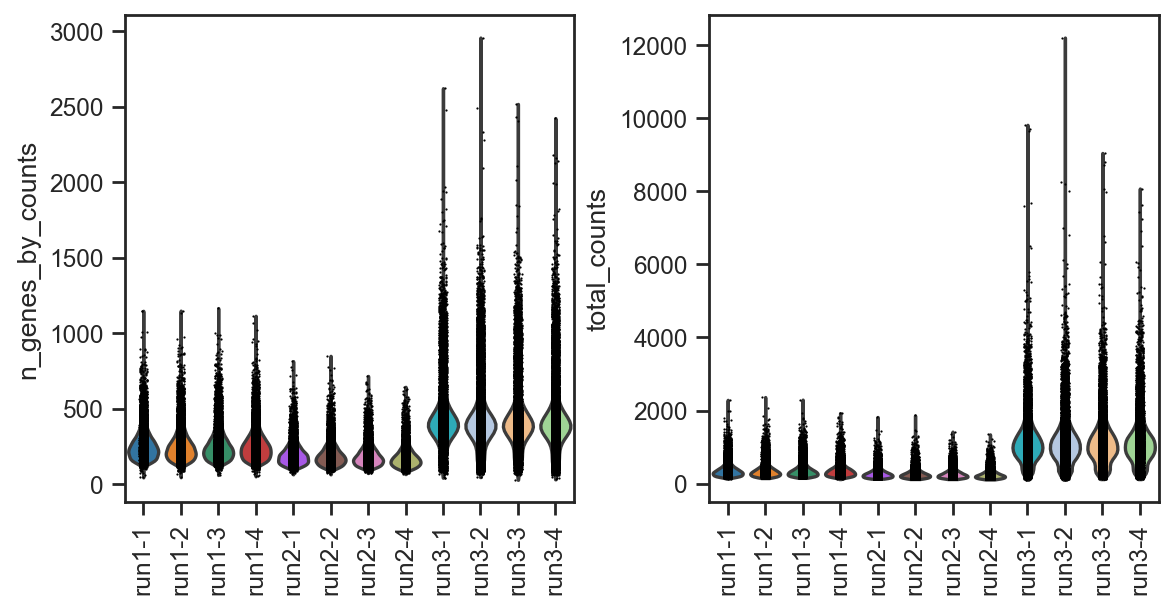

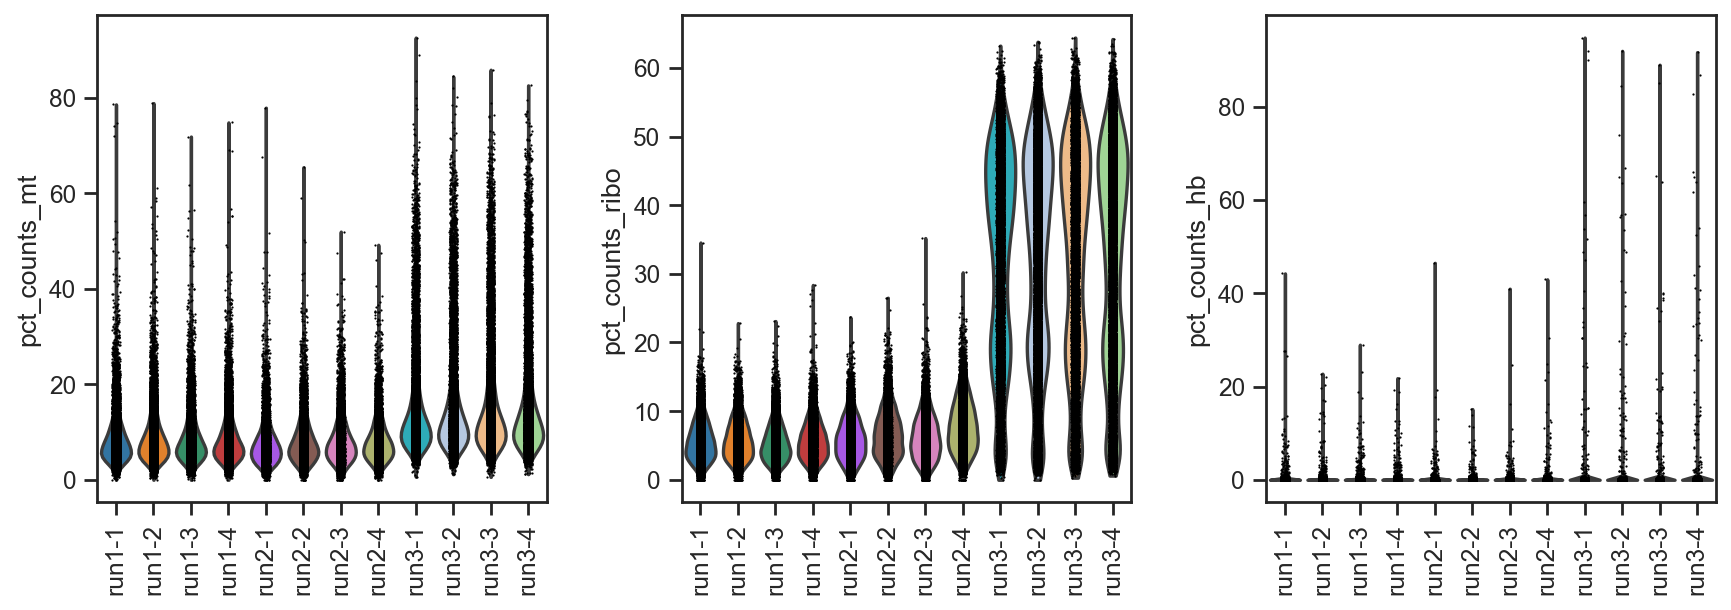

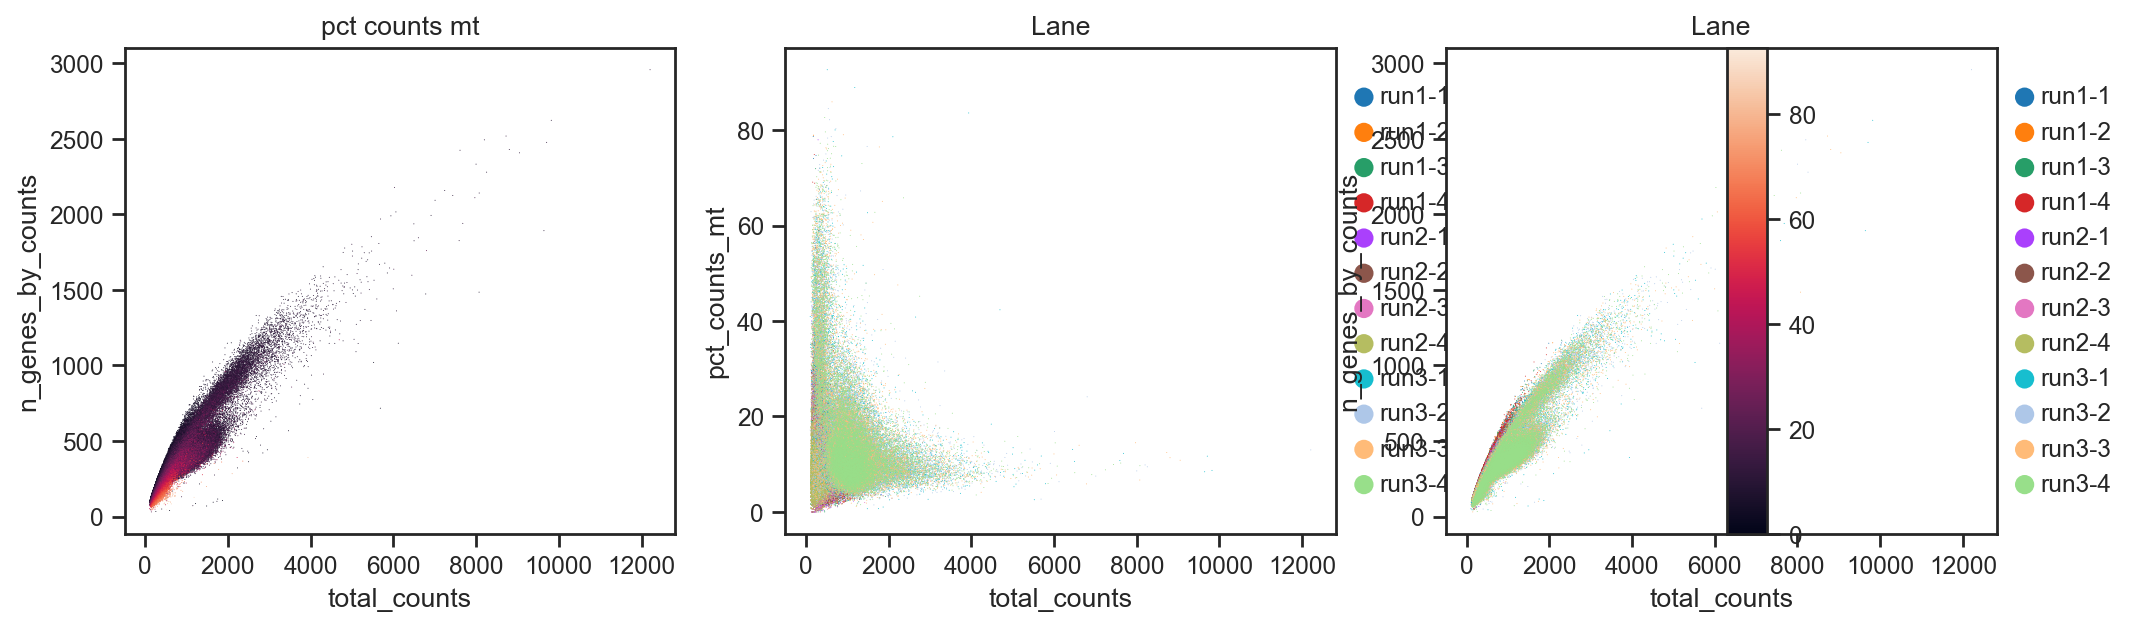

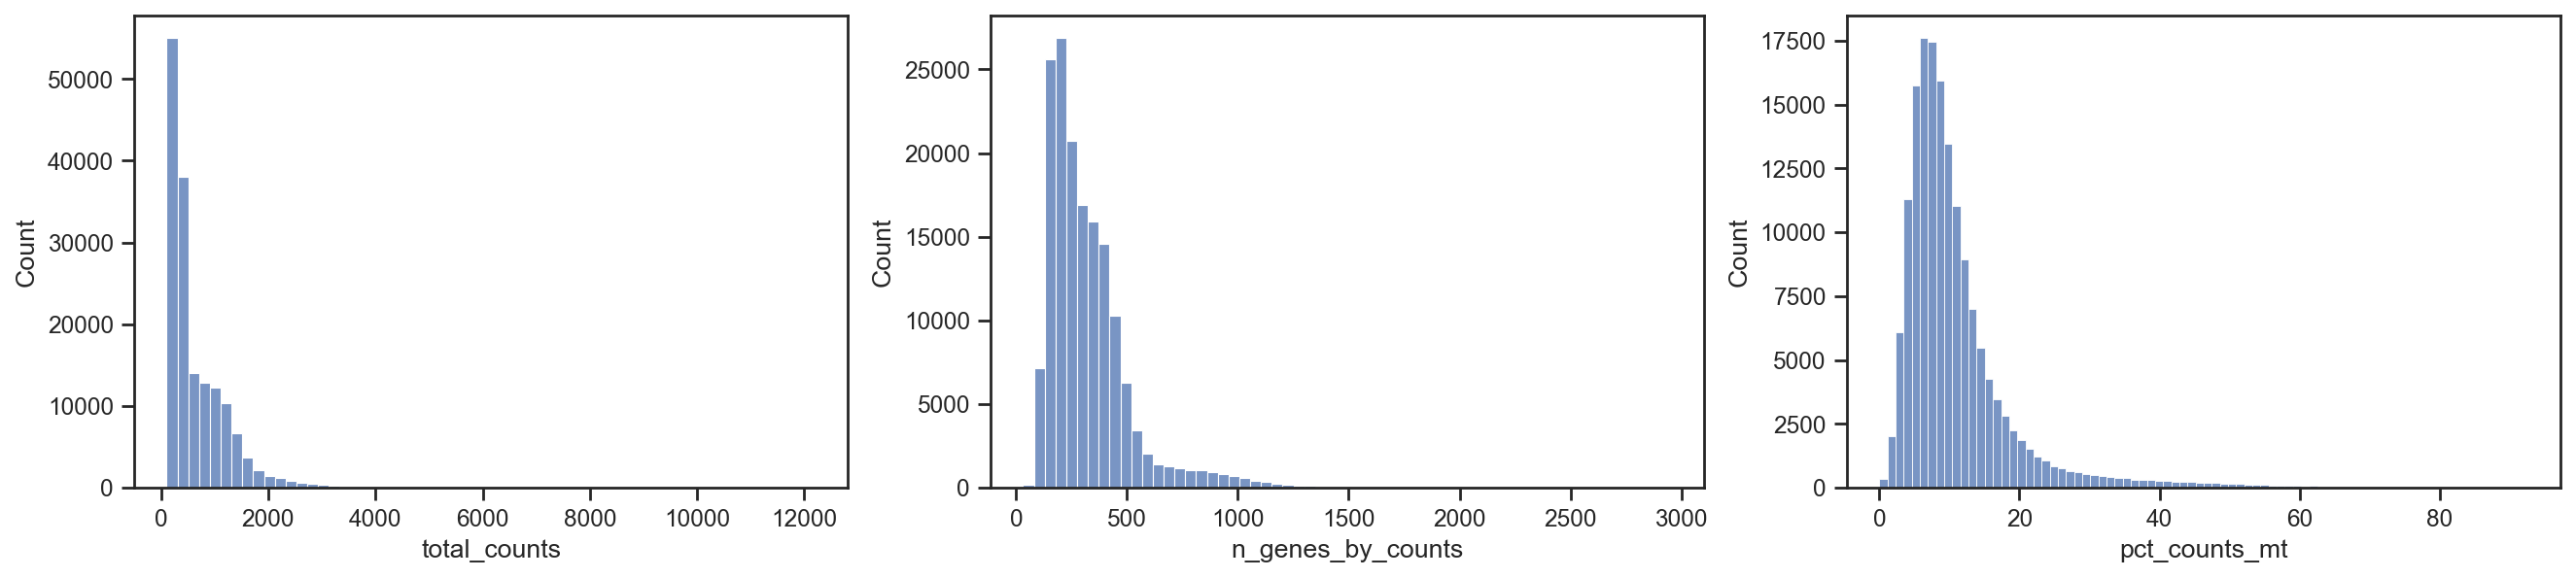

In [7]:
### params
inputPath = './dataOutput/adata/seurat_demux.h5ad'
outputPath = './dataOutput/adata/normalized.h5ad'
plt.rcParams['figure.figsize'] = 4,4
seed = 123
np.random.seed(seed)

# load integrated data
adata = sc.read(inputPath, cache=False)

print('METRICS FOR ORIGINAL DATA: \n')
printMetrics(adata, ["Lane", "Sample"])

# clean up for metric printing
adata.obs['batch'] = [item.split('-')[0].split('run')[-1] for item in adata.obs['Lane']] 
adata.obs["orig_ident"] = adata.obs["orig.ident"]
del adata.obs["orig.ident"]

# Save cell count raw data values
qc_cell_counts_by_sample = pd.DataFrame(columns=["Sample", "batch", "orig_ident"]).set_index(["Sample", "batch", "orig_ident"])
qc_cell_counts_by_lane = pd.DataFrame(columns=["Lane", "orig_ident"]).set_index(["Lane", "orig_ident"])

curr_values = pd.DataFrame(adata.obs.groupby(["Sample", "batch"])["orig_ident"].value_counts())
curr_values.columns = ["Raw data"]
qc_cell_counts_by_sample = qc_cell_counts_by_sample.join(curr_values, how="outer")

curr_values = pd.DataFrame(adata.obs.groupby(["Lane"])["orig_ident"].value_counts())
curr_values.columns = ["Raw data"]
qc_cell_counts_by_lane = qc_cell_counts_by_lane.join(curr_values, how="outer")

# Remove non-RA samples and matching controls
adata = adata[~adata.obs["Sample"].isin(['RA02_1_C_F', 'RA12_1_C_F', 'RA13_1_C_M', 'RA11_1_C_M', 'RA14_1_C_F', "Control02_1_C_F", "Control11_1_C_M", "Control12_1_C_F","Control13_1_C_M", "Control14_1_C_F", 'nan'])]
adata = labelSampleType(adata)
adata = adata[adata.obs["sampleType"]!="AS"]

# Save cell count relevant data values (removed non-RA)
print('AFTER REMOVING NON-RA DATA: \n')
printMetrics(adata, ["Lane", "Sample"])

curr_values = pd.DataFrame(adata.obs.groupby(["Sample", "batch"])["orig_ident"].value_counts())
curr_values.columns = ["RA Samples Only"]
qc_cell_counts_by_sample = qc_cell_counts_by_sample.join(curr_values, how="outer")

curr_values = pd.DataFrame(adata.obs.groupby(["Lane"])["orig_ident"].value_counts())
curr_values.columns = ["RA Samples Only"]
qc_cell_counts_by_lane = qc_cell_counts_by_lane.join(curr_values, how="outer")

# Remove doublets
adata = adata[adata.obs["demux.doublet.call"]=="SNG",:]
adata = cleanRAData(adata, plot = True)

# Save cell count values without doublets
print('AFTER REMOVING DOUBLETS: \n')
printMetrics(adata, ["Lane", "Sample"])

curr_values = pd.DataFrame(adata.obs.groupby(["Sample", "batch"])["orig_ident"].value_counts())
curr_values.columns = ["After removing doublets"]
qc_cell_counts_by_sample = qc_cell_counts_by_sample.join(curr_values, how="outer")

curr_values = pd.DataFrame(adata.obs.groupby(["Lane"])["orig_ident"].value_counts())
curr_values.columns = ["After removing doublets"]
qc_cell_counts_by_lane = qc_cell_counts_by_lane.join(curr_values, how="outer")

# Remove platelets (> 1 count of platelet/megakaryocyte gene markers (PF4, SDPR, PPBP, GNG11 (not in dataset)))
plt_genes = sc.get.obs_df(adata, keys=["PF4", "GNG11", "PPBP"])
adata = adata[adata.obs.index.isin(plt_genes[plt_genes.sum(axis=1) < 1].index)]

# add metrics for QC and preprocess according to thresholds
adata = plotQCMetrics(adata, groupby="Lane", out_path="./figures/QC_plots_raw")
qc_by_sample_table = adata.obs.groupby("Lane")["nCount_RNA", "nFeature_RNA", "n_genes_by_counts", "total_counts_mt", "pct_counts_mt",  
                            "total_counts_ribo", "pct_counts_ribo", "total_counts_hb", "pct_counts_hb"].describe(percentiles=[0.5])
qc_by_sample_table.to_csv("./figures/QC_by_lane_before_filter_STable.csv")

# More QC metrics for supplemental table
qc_by_sample_table = adata.obs.groupby(["Sample", "batch"])["nCount_RNA", "nFeature_RNA", "n_genes_by_counts", "total_counts_mt", "pct_counts_mt",  
                            "total_counts_ribo", "pct_counts_ribo", "total_counts_hb", "pct_counts_hb"].describe(percentiles=[0.5])
qc_by_sample_table.to_csv("./figures/QC_by_sample_before_filter_STable.csv")

# Filtering
adata = set_filters(adata, min_cells=3, min_genes=100, max_genes=1000, min_count=0, max_count=2000, 
               mtpct=20, rbpct=3, remove_rb=False, remove_hb=False, remove_mt=False) 

adata = adata[adata.obs.sort_values("demux_RD_PASS").index]

# Save cell count values after filtering
print('AFTER FILTERING: \n')
printMetrics(adata, ["Lane", "Sample"])

curr_values = pd.DataFrame(adata.obs.groupby(["Sample", "batch"])["orig_ident"].value_counts())
curr_values.columns = ["After filtering"]
qc_cell_counts_by_sample = qc_cell_counts_by_sample.join(curr_values, how="outer")
qc_cell_counts_by_sample.to_csv("./figures/cell_counts_by_sample_STable.csv")

curr_values = pd.DataFrame(adata.obs.groupby(["Lane"])["orig_ident"].value_counts())
curr_values.columns = ["After filtering"]
qc_cell_counts_by_lane = qc_cell_counts_by_lane.join(curr_values, how="outer")
qc_cell_counts_by_lane.to_csv("./figures/cell_counts_by_lane_STable.csv")

# More QC metrics for supplemental table
qc_by_sample_table = adata.obs.groupby("Lane")["nCount_RNA", "nFeature_RNA", "n_genes_by_counts", "total_counts_mt", "pct_counts_mt",  
                            "total_counts_ribo", "pct_counts_ribo", "total_counts_hb", "pct_counts_hb"].describe(percentiles=[0.5])
qc_by_sample_table.to_csv("./figures/QC_by_lane_before_filter_STable.csv")

qc_by_sample_table = adata.obs.groupby(["Sample", "batch"])["nCount_RNA", "nFeature_RNA", "n_genes_by_counts", "total_counts_mt", "pct_counts_mt",  
                            "total_counts_ribo", "pct_counts_ribo", "total_counts_hb", "pct_counts_hb"].describe(percentiles=[0.5])
qc_by_sample_table.to_csv("./figures/QC_by_sample_after_filter_STable.csv")


In [ ]:

# Normalize and log-scale. Store raw counts in adata.raw
# NOTE: scaling & regress out performed after select HVG in later cell
adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4, key_added="norm_library_size")
sc.pp.log1p(adata) 

# QC plotting
sc.pl.highest_expr_genes(adata, n_top=20);

## Cell cycle scoring
#Remove s and g2m gene not in our dataset ['MLF1IP', 'FAM64A', 'HN1']
s_genes_list = ["MCM5","PCNA", "TYMS","FEN1", "MCM2","MCM4","RRM1","UNG","GINS2","MCM6","CDCA7","DTL","PRIM1","UHRF1", 
                "HELLS","RFC2","RPA2","NASP","RAD51AP1","GMNN","WDR76","SLBP","CCNE2","UBR7","POLD3","MSH2",
                "ATAD2", "RAD51","RRM2","CDC45","CDC6","EXO1","TIPIN","DSCC1",  "BLM","CASP8AP2","USP1","CLSPN","POLA1",
                "CHAF1B","BRIP1" ,"E2F8"]

g2m_genes_list = ["HMGB2","CDK1","NUSAP1","UBE2C","BIRC5","TPX2","TOP2A","NDC80","CKS2","NUF2","CKS1B","MKI67","TMPO",
             "CENPF","TACC3","SMC4","CCNB2","CKAP2L", "CKAP2","AURKB","BUB1","KIF11","ANP32E","TUBB4B",
             "GTSE1","KIF20B","HJURP","CDCA3","CDC20","TTK","CDC25C","KIF2C","RANGAP1","NCAPD2",
             "DLGAP5","CDCA2","CDCA8","ECT2","KIF23","HMMR","AURKA","PSRC1","ANLN","LBR","CKAP5","CENPE","CTCF",
                  "NEK2","G2E3","GAS2L3","CBX5","CENPA"]

sc.tl.score_genes_cell_cycle(adata = adata, s_genes = s_genes_list,g2m_genes = g2m_genes_list )
adata.obs["cell_cycle_diff"] = adata.obs["S_score"] - adata.obs["G2M_score"]

### add metadata
RA_meta = pd.read_csv("./dataInput/patientData/RA_metadata_merged_221118.csv", index_col=0, encoding="ISO-8859-1")

adata.obs = adata.obs[[c for c in adata.obs.columns if c not in RA_meta.columns]]
adata.obs = adata.obs.reset_index(drop=False)

RA_meta['group']= RA_meta['group'].apply(str)
RA_meta["sample_group"] = RA_meta["sample"]+ RA_meta["group"]
adata.obs["sample_group"] = adata.obs["Sample"].astype(str) + adata.obs["batch"].astype(str)
adata.obs = adata.obs.merge(RA_meta, how="left", left_on="sample_group", right_on="sample_group")
adata.obs = adata.obs.set_index("barcodes", drop=True)

# formattting to make adata happy
adata.obs["mtx"] = adata.obs["mtx"].astype(str)
adata.obs["tnf"] = adata.obs["tnf"].astype(str)
adata.obs["early_ra"] = ["Control" if x=="Control"
                         else "True" if y==True 
                         else "False" for x,y in zip(adata.obs["sampleType"],adata.obs["early_ra"])]
adata.obs["acr2010"] = ["Control" if x=="Control"
                         else "True" if y==True 
                         else "False" for x,y in zip(adata.obs["sampleType"],adata.obs["acr2010"])]
adata.obs["acr1987"] = ["Control" if x=="Control"
                         else "True" if y==True 
                         else "False" for x,y in zip(adata.obs["sampleType"],adata.obs["acr1987"])]

# label values
adata.obs["activity_python_crp"] = ["control" if d=="control"
                                else "NA" if np.isnan(r)
                                else "Remission" if r<2.6
                               else "Low" if r<3.2
                               else "Moderate" if r<=5.1
                               else "High" for d, r in zip(adata.obs["dx"], adata.obs["MY_das28crp4"])]

adata.obs["activity_python_binary_crp"] = ["control" if d=="control"
                                       else "NA" if "NA" in r
                                else "No" if "Remission" in r
                               else "No" if "Low" in r
                               else "Yes" if "Moderate" in r
                               else "Yes" for d, r in zip(adata.obs["dx"], adata.obs["activity_python_crp"])]

# label values
adata.obs["activity_python_esr"] = ["control" if d=="control"
                                else "NA" if np.isnan(r)
                                else "Remission" if r<2.6
                               else "Low" if r<3.2
                               else "Moderate" if r<=5.1
                               else "High" for d, r in zip(adata.obs["dx"], adata.obs["MY_das28esr4"])]

adata.obs["activity_python_binary_esr"] = ["control" if d=="control"
                                       else "NA" if "NA" in r
                                else "No" if "Remission" in r
                               else "No" if "Low" in r
                               else "Yes" if "Moderate" in r
                               else "Yes" for d, r in zip(adata.obs["dx"], adata.obs["activity_python_esr"])]


adata.obs["smoker_any"] = ["control" if c=="control"
                           else "Unknown" if type(m)!=str
                           else "No" if "Never" in m
                           else "Yes" for c,m in zip(adata.obs["dx"], adata.obs["smoke_status"]) ]

adata.obs["age_group"] = ["Unknown" if m==np.nan
                          else "Old" if m > 45
                          else "Young" for m in adata.obs["age"]]
adata.obs["age_group"].value_counts()

# print final metrics
print('\nCELLS x GENES = ' + str(adata.shape) + '\n')
    
print('METRICS FOR RAW DATA: \n')
printMetrics(adata, ["sampleType", "sex", "Lane", "Sample"])
print(adata.obs.groupby(["Sample", "batch"])["orig_ident"].value_counts())

# normalized adata has raw values in .raw and log-norm values in .X
#adata.write(outputPath)


## Cell counts
Tables with cell counts per patient and per annotated subgroup

In [8]:
inputPath = './dataOutput/adata/final.h5ad'
adata = sc.read(inputPath)
adata.uns['log1p']['base'] = None 

# Get counts and save
subset_counts = adata.obs.groupby("fine_annot").count()[["sample"]]
subset_counts.to_csv("./figures/PerSubsetCounts_STable.csv")
